In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm, gaussian_kde

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import statsmodels.api as sm

import pymc as pm
import arviz as az


# Ignore all warnings
warnings.filterwarnings("ignore")


def plot_model_coef_magnitude(model):
    plt.bar(model.params.index, model.params)
    plt.title('Size of model coefficients')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
RANDOM_SEED = 42

## 1. Data pre-processing

In this first section we load and pre-process the data. 

For continious columns we impute missing values with the median value and then normalize. For categorical columns we impute missing values with the most frequent value and then one-hot encode them creating $k-1$ indicator columns per categorical column, where $k$ indicates the number of levels. 

Note for classical logistic regression we have to drop the first level when one-hot encoding as the design matrix $X$ otherwise becomes singular and non-invertable due to colinearity of the one-hot encoded columns (explanation in the cell below for the interested).

#### Explanation of issues arising from collinearity (skip if not interested)

When the "Sex" column is one-hot encoded and the first level is not dropped we have that $Sex_{male} + Sex_{female} = 1$ for all rows in X. In other words, one of the columns is redundant as it is a perfect linear combination of the other.

This is a problem because classical Logistic Regression finds the optimal parameter values using Maximum Likelihood, where the solution is something like this:

$$
\begin{align*}
\hat{\beta} = (X^TX)^{-1}X^Ty
\end{align*}
$$

When there is perfect collinearity in X, the matrix $X^TX$ is not invertible and the optimizer will not converge.

**Later we will see that this is not a problem in the Bayesian approach!**

In [2]:
# ---- Config ----
numeric_cols = ["Age", "Fare"]
categorical_cols = ["Sex", "Pclass", "SibSp", "Parch", "Embarked"]
target_col = "Survived"

# ---- Load & keep only needed cols ----
df = pd.read_csv("Titanic-Dataset.csv")
df = df[[target_col] + numeric_cols + categorical_cols].copy()

# ---- Split data ----
X = df.drop(columns=[target_col])
y = df[target_col]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- Preprocessing pipelines ----
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore",
                          sparse_output=False, dtype=int)),
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols),
])

# ---- Fit on train, transform both ----
X_train_arr = preprocessor.fit_transform(X_train_raw)
X_test_arr  = preprocessor.transform(X_test_raw)

# ---- Feature names (works on sklearn ≥1.0) ----
feature_names = preprocessor.get_feature_names_out()

# ---- Back to DataFrames ----
X_train = pd.DataFrame(X_train_arr, columns=feature_names, index=X_train_raw.index)
X_test  = pd.DataFrame(X_test_arr,  columns=feature_names, index=X_test_raw.index)

# (Optional) Drop exact duplicate columns (rare but safe)
X_train = X_train.T.drop_duplicates().T
X_test = X_test[X_train.columns]

# ---- Add intercept ----
X_train = X_train.copy()
X_train.insert(0, 'const', 1.0)

X_test = X_test.copy()
X_test.insert(0, 'const', 1.0)

## 2. Classical Logistic Regression

We start by fitting a classical/standard logistic regression model, where the model can be writen as:

$$\begin{align*}
y_n|\mathbf{w} &\sim \text{Ber}(\sigma(\mathbf{\beta}^T \mathbf{x_n}))\\
\end{align*}$$

where
$$
\sigma(t)=\frac{1}{1+e^{-t}},\quad 
\mathbf x_n=(1,\ldots)^\top,\ \mathbf{\beta}=(\beta_0,\ldots, \beta_p)^\top.
$$
Note here we assume that $\beta_0$ is the intercept and that the first entry in $\mathbf{x_n}$ is always $1$.

### 2.1 Unregularized Logistic Regression

We now fit the model and see that the model did not converge even though we made sure to drop the first level when one-hot encoding...

We also see that some of the coefficients take on large values and are associated with large standard errors, which is a classical sign of divergence of the optimizer.

In [3]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

         Current function value: 0.425459
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      692
Method:                           MLE   Df Model:                           19
Date:                Thu, 21 Aug 2025   Pseudo R-squ.:                  0.3609
Time:                        20:16:42   Log-Likelihood:                -302.93
converged:                      False   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 4.317e-61
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.6471      0.367      7.222      0.000       1.929       3.365
num__Age           -0.4592      0.121     -3.780  

In [4]:
pred_probs = model.predict(X_test)
tpred = (pred_probs >= 0.5).astype(int)

print(classification_report(y_test, tpred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



#### We see large coefficients for multiple inputs:

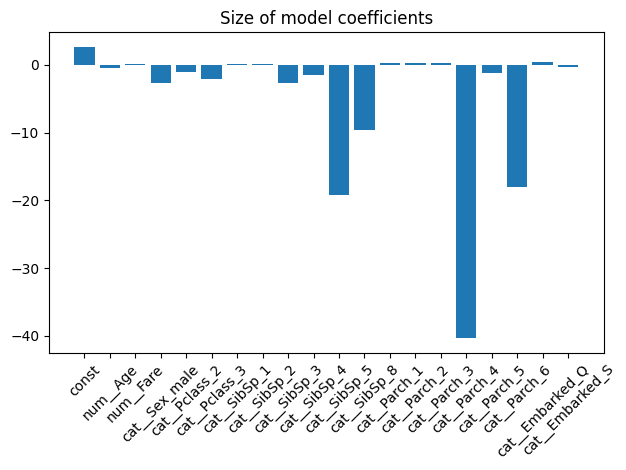

In [5]:
plot_model_coef_magnitude(model)

#### These indicator columns consists of almost all 0's and pose a problem for the Maximum Likelihood solution

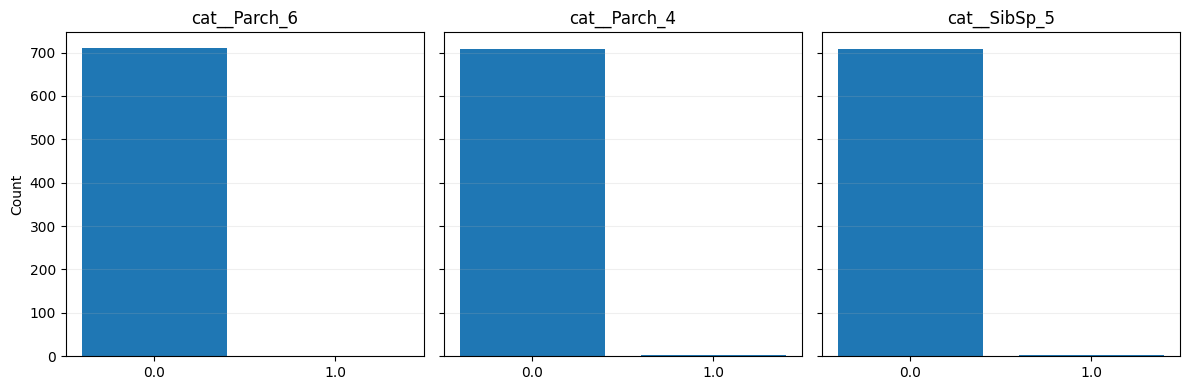

In [6]:
import matplotlib.pyplot as plt

# pick your 3 series (replace as needed)
s1 = X_train.cat__Parch_6
s2 = X_train.cat__Parch_4
s3 = X_train.cat__SibSp_5

series = [s1, s2, s3]
titles = ["cat__Parch_6", "cat__Parch_4", "cat__SibSp_5"]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True)

for s, ax, title in zip(series, axes, titles):
    vc = s.value_counts().sort_index()
    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(title)
    ax.set_xlabel("")           # optional: cleaner look
    ax.grid(axis="y", alpha=0.2)

axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()

#### We see that the parameter optimization did not converge, meaning that there was no stable solution to the Maximum Likelihood optimization. 

This is a general issue with logistic regression, when an indicator column contains almost all 0 and only a few 1's, then the maximum likelihood solution for the coefficient of that column is $\pm \inf$.

We can see this from the likelihood that for $y=0$ is given by:
$$
\begin{align*}
\ell(\beta)&=\sum\left[y_i \log p_i+\left(1-y_i\right) \log \left(1-p_i\right)\right],\\
&=  \sum\left[\log \left(1-p_i\right)\right],\\
\end{align*}
$$

where

$$
\begin{align}
\quad p_i=\sigma\left(\eta_i\right), \eta_i=x_i^{\top} \beta .
\end{align}
$$

We can see that these terms are maximized when $\beta \rightarrow-\infty$ as $\sigma(x_i^T \beta) \rightarrow 0$ which will maximise each term in the likehood $\rightarrow \log 1=0$. Hence, in our case where we have indicator columns that are almost all 0's the maximum likelihood solution is $\pm \inf$, indicated by the large coefficients and very high standard errors in the model summary above.

#### A solution is to impose regularization on the model parameters OR use a Bayesian approach where the priors on the coeficients avoid $w \rightarrow \pm \infty$.

### 2.2 Regularised Logistic Regression

#### If we use a regularized logistic regression model we see that the Maximum Likelihood optimization now converges...

In [7]:
model = sm.Logit(y_train, X_train).fit_regularized(alpha=0.08, L1_wt=0.0)  # ridge (L2)
print(model.summary())  # note: fewer inferential stats vs. unpenalized fit

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4290206855395788
            Iterations: 276
            Function evaluations: 277
            Gradient evaluations: 276
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      692
Method:                           MLE   Df Model:                           19
Date:                Thu, 21 Aug 2025   Pseudo R-squ.:                  0.3602
Time:                        20:16:42   Log-Likelihood:                -303.28
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 6.038e-61
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

#### We know see that the magnitude of the ceofficients are being kept under control be the penalisation/regularisation term.

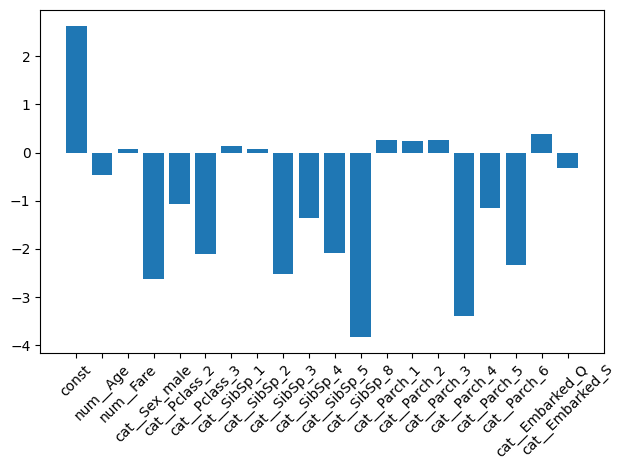

In [8]:
plt.bar(model.params.index, model.params)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
pred_probs = model.predict(X_test)
tpred = (pred_probs >= 0.5).astype(int)

print(classification_report(y_test, tpred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



## 3. Bayesian Logistic Regression

In [10]:
import math

def log_sigmoid(z):
    return -np.logaddexp(0, -z)

def log1m_sigmoid(z):
    return -np.logaddexp(0, z)

def normal_pdf(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)

def student_t_pdf(x, nu, mu, sigma):
    c = math.gamma((nu + 1.0) / 2.0) / (math.gamma(nu / 2.0) * math.sqrt(nu * math.pi) * sigma)
    z2 = ((x - mu) / sigma) ** 2
    return c * (1.0 + (1.0 / nu) * z2) ** (-(nu + 1.0) / 2.0)

def logit(p):
    return np.log(p / (1 - p))


def get_inference_stats(idata):
    """
    Helper function to print parameter estimation statistics from Monte Carlo sampling.
    """
    
    tbl = az.summary(idata, var_names=["beta"], kind="stats")
    rhat_series = az.rhat(idata, var_names=["beta"]).to_array().to_series()
    
    # Make the Series index match az.summary’s labels: "beta[0]", "beta[1]", ...
    def to_summary_label(idx):
        # idx can be e.g. "alpha" or ("beta", 0)
        if isinstance(idx, tuple):
            name = idx[0]
            inds = ",".join(str(i) for i in idx[1:])
            return f"{name}[{inds}]"
        return idx

    rhat_series.index = [to_summary_label(i) for i in rhat_series.index]
    rhat_series.name = "r_hat"

    # Join to the right of the summary table
    tbl_with_rhat = tbl.join(rhat_series, how="left")
    
    return tbl_with_rhat

### 3.1 Bayesian ML

The basis of Bayesian Machine Learning is to our great surprise, Bayes theorem that states:

$$
\begin{align}
p(\beta \mid \ y, X_{train}) &= \frac{p(y \mid \beta, X_{train}) p(\beta)}{{p(y)}} \\
&\propto p(y \mid \beta, X_{train}) p(\beta),\\
\end{align}
$$

where $p(\beta)$ is the prior distribution of the model parameters, $p(y \mid \beta, X_{train})$ is the likelihood, $p(y)$ is the marginal distribution of the data.

Explanation of distributions:
- The prior is where we can encode prior information or expert knowledge about the parameters into the model. 
- The likelihood is the well-known term from classical machine learning that is used the optimize the model parameters. 
- The marginal likelihood is in this case the probability of surviving and not surviving respectively, with the values of X summed or marginalized out. The marginal likelihood acts as a normalitation term and ensures that the posterior distribution sums to 1. 
- The posterior distribution is then the distribution of the model parameters after having observed the data and accounted for the prior distribution.


In short, Bayes theorem is the foundation of Bayesian machine learning and is used to combine our prior knowdledge of the model parameters with the data.  Since we express both the prior and the likelihood as distributions, which allows us to quantify the uncertainty w.r.t. the model parameters. This uncertainty, which is thrown away in classical machine learning, we include in our posterior predictive distribution and allows us to express the uncertainty w.r.t. to our predictions which is useful in many cases, e.g. if we want to set a threshold on the uncertainty and not make predictions when the model is too uncertain.

### 3.1 Building a baseline Bayesian Logistic Regression model



We can now write up the model including the prior distributions. For the prior distribution on the intercept, it is normal to use the baseline probability ($p_{baseline}$) of surving as the mean of the Gaussian (note that we need to transform it to logits).

We choose Gaussian priors for all model coefficients and the model can therefore be written as:
$$
\begin{aligned}
&\text{For } n=1,\dots,N: && y_n \mid \mathbf \beta \sim \operatorname{Bernoulli}\!\big(\sigma(\mathbf{x_n}^\top \mathbf{\beta})\big),\\
&\text{Priors:} && \beta_0 \sim \mathcal N(\text{logit}(p_{baseline}),\sigma_{weak}^2)\quad\text{(weak prior on intercept)},\\
&&& \beta_j \sim \mathcal N(0,\sigma_{weak}^2)\quad \text{for } j\in\{1,\dots,p\}\\
\end{aligned}
$$

where
$$
\sigma(t)=\frac{1}{1+e^{-t}},\quad 
\mathbf x_n=(1,\ldots)^\top,\ \quad  \mathbf \beta=(\beta_0,\ldots,\beta_p)^\top, \quad  p_{baseline} = 0.38, \quad \sigma_{weak} = 1.
$$

Note here we assume that $\beta_0$ is the intercept and that the first entry in $\mathbf{x_n}$ is always $1$.

The logit of the baseline probability of surviving is used as the mean for the prior on the intercept:

In [11]:
baseline_p = y_train.mean()
print(f'Baseline probability of surviving: {baseline_p: .2f}')

Baseline probability of surviving:  0.38


Note that the scale of the prior, ie. the standard deviation, should match the scale of the coefficients ($\beta_j$) which means that you need to know the scale of the coefficients in order to be able to define weak and informative priors.

In [12]:
sigma_weak = 1

# N(0,1) priors for all parameters
p = X_train.values.shape[1]
beta_mu    = np.zeros(p)
beta_sigma = np.full(p, sigma_weak)

# Prior for the intercept w. mu set to the baseline probability of surviving
beta_mu[0] = logit(baseline_p)

with pm.Model() as blr:
    X_data = pm.Data("X", X_train)
    y_data = pm.Data("y", y_train)
    
    # Priors (weakly-informative)
    beta  = pm.Normal("beta", mu=beta_mu, sigma=beta_sigma, shape=p)
    
    # Linear predictor and inverse link
    eta = pm.math.dot(X_data, beta)
    p   = pm.Deterministic("p", pm.math.sigmoid(eta))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_data)

    # ---- 4) Fit with NUTS ----
    idata = pm.sample(
        draws=4000, tune=1000, chains=4, target_accept=0.9, random_seed=RANDOM_SEED
    )

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4 seconds.


Below we see that imposing priors resulted in parameter estimates with lower variance compared to the maximum likelihood estimate above where the standard error was very high.

In [13]:
inference_stats_table = get_inference_stats(idata)
print(inference_stats_table)

           mean     sd  hdi_3%  hdi_97%     r_hat
beta[0]   2.193  0.311   1.612    2.778  1.001705
beta[1]  -0.412  0.113  -0.617   -0.193  1.000156
beta[2]   0.157  0.136  -0.090    0.419  1.000202
beta[3]  -2.392  0.207  -2.795   -2.016  1.000212
beta[4]  -0.716  0.303  -1.293   -0.156  1.000223
beta[5]  -1.812  0.297  -2.385   -1.267  1.000209
beta[6]   0.205  0.233  -0.205    0.673  0.999956
beta[7]   0.130  0.502  -0.798    1.097  1.000136
beta[8]  -1.315  0.663  -2.568   -0.093  1.000017
beta[9]  -0.829  0.587  -1.948    0.250  1.000198
beta[10] -0.434  0.858  -1.998    1.207  0.999999
beta[11] -0.925  0.810  -2.465    0.571  1.000847
beta[12]  0.213  0.295  -0.363    0.736  1.000320
beta[13]  0.091  0.366  -0.585    0.793  1.000262
beta[14]  0.193  0.717  -1.197    1.495  1.001063
beta[15] -0.869  0.807  -2.437    0.609  1.000882
beta[16] -0.583  0.742  -1.946    0.849  1.000515
beta[17] -0.397  0.915  -2.101    1.326  1.000147
beta[18]  0.392  0.392  -0.334    1.129  0.999998


In [14]:
with blr:
    pm.set_data({"X": X_test})
    p_pred = pm.sample_posterior_predictive(idata, var_names=["p"])

# Point predictions (posterior mean prob)
p_draws = p_pred.posterior_predictive["p"].stack(sample=("chain","draw")).values  # shape: (n_test, n_draws)
p_mean  = p_draws.mean(axis=1)

yhat_test = (p_mean >= 0.5).astype(int)
print(classification_report(y_test, yhat_test))

Sampling: []


              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



### 3.2 Choosing a prior

We have now fitted a basic Bayesian Logistic Regression model, but we have not included any prior knowledge that we might have into the model. Lets do that!

As an example we might know that passengers travelling on third class (the poor people) have a lower probability of surviving and we can easily include that knowledge in our Bayesian Logistic Regression model. To include this information in the model we impose a prior for the parameter/coefficient that controls the indicator column that indicates whther the passenger travelled on third class ($\beta_{\text{Pclass}=3}$).

In this case we just choose Gaussian priors for all coefficients, however there are many otgher distributions to choose from that can encode different beliefs based on the shape of the distribution. As an example the Student-t distribution is useful when we expect a larger effect (larger coefficients) as the tails of the distribution is heavier than on the Gaussian.

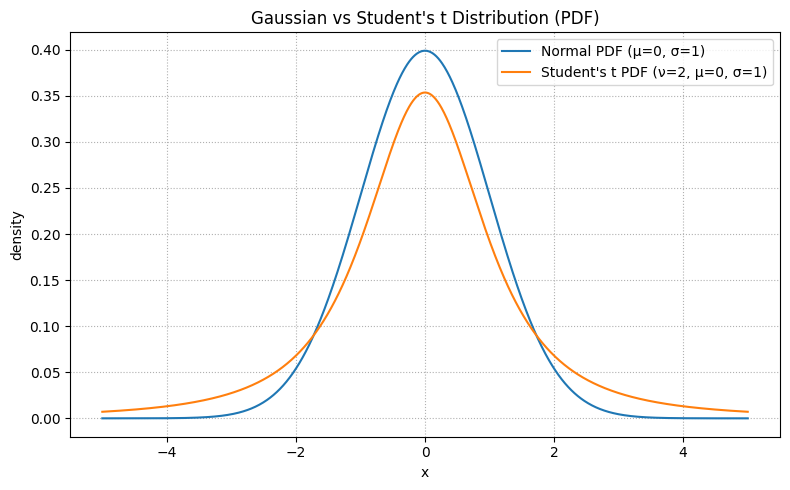

In [15]:
mu = 0.0
sigma = 1.0
nu = 2.0  # degrees of freedom for Student's t
x = np.linspace(-5, 5, 1000)

# ---- Compute PDFs ----
y_norm = normal_pdf(x, mu=mu, sigma=sigma)
y_t = student_t_pdf(x, nu=nu, mu=mu, sigma=sigma)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(x, y_norm, label=f"Normal PDF (μ={mu:g}, σ={sigma:g})")
plt.plot(x, y_t, label=f"Student's t PDF (ν={nu:g}, μ={mu:g}, σ={sigma:g})")
plt.title("Gaussian vs Student's t Distribution (PDF)")
plt.xlabel("x")
plt.ylabel("density")
plt.grid(True, which="both", linestyle=":", linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

When we define a prior we talk about how informative it is, ie. how much the probability mass is centered on a specific value range (how wide or narrow).

Below I visualize two Gaussian priors, one more informative than the other seen by the fact it assigns the probability to smaller range than the weak prior. I also visualize the uniform distribution which is the most un-informative prior.

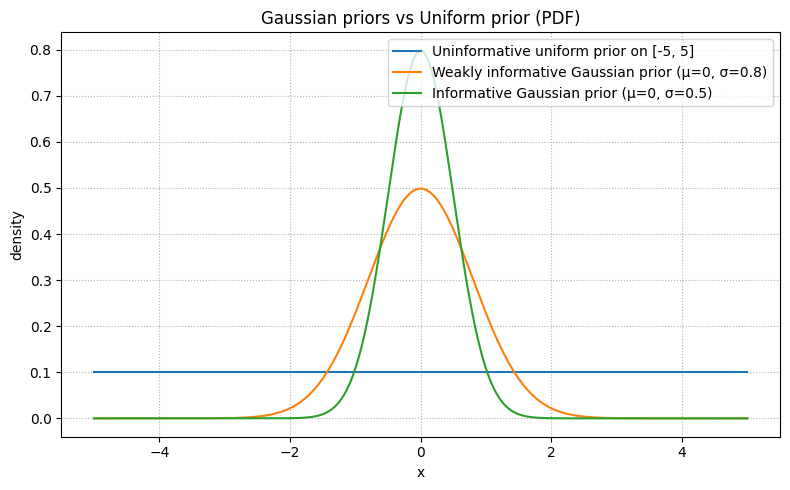

In [16]:
x = np.linspace(-5, 5, 1000)
mu = 0.0
sigma_weak = 0.8
sigma_strong = 0.5

y_weak = normal_pdf(x, mu, sigma_weak)
y_strong = normal_pdf(x, mu, sigma_strong)

a, b = -5, 5
y_uniform = np.full_like(x, 1/(b - a))

plt.figure(figsize=(8, 5))
plt.plot(x, y_uniform, label=f"Uninformative uniform prior on [{a}, {b}]")
plt.plot(x, y_weak, label=f"Weakly informative Gaussian prior (μ={mu:g}, σ={sigma_weak:g})")
plt.plot(x, y_strong, label=f"Informative Gaussian prior (μ={mu:g}, σ={sigma_strong:g})")
plt.title("Gaussian priors vs Uniform prior (PDF)")
plt.xlabel("x"); plt.ylabel("density")
plt.grid(True, which="both", linestyle=":", linewidth=0.8)
plt.legend(); plt.tight_layout(); plt.show()


### 3.3 Adding an informative prior

We can now write up the model including the prior distributions.

We again choose Gaussian priors for all model coefficients, but this time we impose a more informative prior on the coefficient associated with the indicator column for third class (cat__Pclass_3)

The model can therefore be written as:
$$
\begin{aligned}
&\text{For } n=1,\dots,N: && y_n \mid \mathbf \beta \sim \operatorname{Bernoulli}\!\big(\sigma(\mathbf{x_n^\top} \mathbf{\beta})\big),\\
&\text{Priors:} && \beta_0 \sim \mathcal N(\text{logit}(p_{baseline}),\sigma_{weak}^2)\quad\text{(weak prior on intercept)},\\
&&& \beta_j \sim \mathcal N(0,\,\sigma_{weak}^2)\quad \text{for } j\in\{1,\dots,p\}\setminus\{5\},\\
&&& \beta_5 \sim \mathcal N(\mu_5,\sigma_{strong}^2),
\end{aligned}
$$

where
$$
\begin{aligned}
\sigma(t)&=\frac{1}{1+e^{-t}},\\
\mathbf x_n&=(1,\ldots)^\top,\\
\mathbf{\beta}&=(\beta_0,\ldots,\beta_p)^\top,\\
p_{baseline} &= 0.38,\\
\sigma_{weak} &= 2.5, \text{(weak prior, wide distribution)}\\
\sigma_{strong} &= 0.3,\text{(strong informative prior, narrow distribution)}\\
\mu_5 &= \text{logit}(p_{Pclass_3}) - \text{logit}(p_{baseline}) = \text{logit}(0.1) - \text{logit}(0.38)
\end{aligned}
$$

Note here we assume that $\beta_0$ is the intercept and that the first entry in $\mathbf{x_n}$ is always $1$. We set $\mu_5$ s.t. we assume that passengers of thrid class have lower baseline chance of surviving (0.1 compared to the baseline of 0.38).

In [24]:
# Priors on beta all set to N(0,1) (below intercept and beta for Pclass_3 get priors set)
p = X_train.shape[1]
beta_mu    = np.zeros(p)
beta_sigma = np.full(p, sigma_weak)

# Prior for the intercept w. larger sigma
beta_mu[0] = logit(baseline_p)

# Prior on Pclass 3
j = X_train.columns.get_loc("cat__Pclass_3") # find index of colum in X
p_class_3 = 0.1        # probability that passengers on class 3 survives
beta_sigma[j] = 0.5    # tighter => stronger prior; loosen if unsure
beta_mu[j] = logit(p_class_3) - logit(baseline_p) 

with pm.Model() as blr:
    X_data = pm.Data("X", X_train)
    y_data = pm.Data("y", y_train)

    # Coefficients: vectorized Normal with a special prior for j
    beta  = pm.Normal("beta", mu=beta_mu, sigma=beta_sigma, shape=p)

    # Linear predictor and inverse link
    eta = pm.math.dot(X_data, beta)
    p   = pm.Deterministic("p", pm.math.sigmoid(eta))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_data)

    idata = pm.sample(
        draws=4000, tune=1000, chains=4, target_accept=0.9, random_seed=RANDOM_SEED, cores=4
    )

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4 seconds.


We have now included our prior belief that passengers travelling on third class has a lower probability of surviving and it did not change the estimate for the $\beta_5$ coefficient as it alligned with the data/likelihood. You can try to change the prior mu to + 1.839 and see that the posterior estimate of the ceof is a compromise between the prior and the likelihood.

In [25]:
inference_stats_table = get_inference_stats(idata)
print(inference_stats_table)

           mean     sd  hdi_3%  hdi_97%     r_hat
beta[0]   2.082  0.281   1.534    2.585  1.000815
beta[1]  -0.407  0.110  -0.617   -0.202  0.999941
beta[2]   0.151  0.128  -0.087    0.391  1.000166
beta[3]  -2.296  0.196  -2.654   -1.921  1.000184
beta[4]  -0.694  0.281  -1.224   -0.166  1.000198
beta[5]  -1.839  0.259  -2.341   -1.364  1.000287
beta[6]   0.230  0.227  -0.183    0.670  1.000060
beta[7]   0.143  0.470  -0.727    1.050  1.000317
beta[8]  -1.029  0.579  -2.086    0.064  1.000050
beta[9]  -0.662  0.535  -1.725    0.292  1.000318
beta[10] -0.288  0.725  -1.611    1.121  1.000114
beta[11] -0.657  0.687  -1.932    0.634  1.000608
beta[12]  0.210  0.280  -0.321    0.724  1.000392
beta[13]  0.090  0.346  -0.550    0.755  1.001122
beta[14]  0.172  0.632  -0.981    1.387  1.000071
beta[15] -0.621  0.690  -1.920    0.668  1.000196
beta[16] -0.421  0.642  -1.619    0.795  1.000084
beta[17] -0.267  0.754  -1.707    1.126  0.999877
beta[18]  0.434  0.363  -0.240    1.124  1.000117


In [26]:
with blr:
    pm.set_data({"X": X_test})
    p_pred = pm.sample_posterior_predictive(idata, var_names=["p"], random_seed=RANDOM_SEED)

# Point predictions (posterior mean prob)
p_draws = p_pred.posterior_predictive["p"].stack(sample=("chain","draw")).values  # shape: (n_test, n_draws)
p_mean  = p_draws.mean(axis=1)

yhat_test = (p_mean >= 0.5).astype(int)
print(classification_report(y_test, yhat_test))

Sampling: []


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



### 3.4 Visualizing the effect of the prior and the likelihood on the posterior distribution over $\beta_5$

Below we visualize the effect of the prior on the estimate for the $\beta_5$ coefficient. 

You can try to set beta_mu[5]=2.0 (opposite the observed effect) and see that the prior pulls the posterior in its direction, but that the data overwhelms the prior, which is a good thing since the prior is wrong according to the data.

To plot the likelihood we rearrange Bayes theorem:
$$
\begin{align}
p(\beta \mid \ y, X_{train}) &= \frac{p(y \mid \beta, X_{train}) p(\beta)}{{p(y)}} \\
&\propto p(y \mid \beta, X_{train}) p(\beta)\\
p(y \mid \beta, X_{train}) &\propto  \frac{p(\beta \mid \ y, X_{train})}{{p(\beta)}}
\end{align}
$$

This means that we can get the likelihood up to a constant as the ratio between the posterior and the prior, which we already have from sampling (posterior) and per definition (prior).

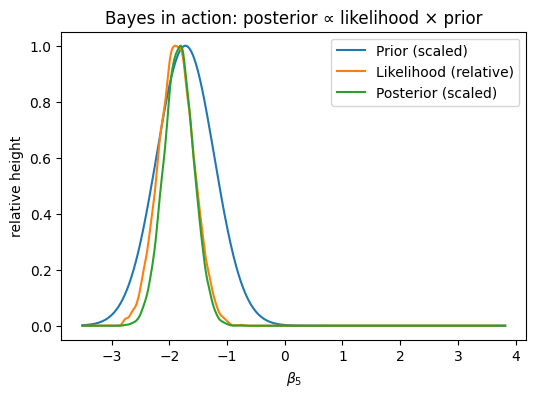

In [27]:
# choose which beta to plot
k = 5

# --- posterior samples of beta_k ---
beta_draws_full = idata.posterior["beta"].values        # shape (chains, draws, p)
beta_draws = beta_draws_full.reshape(-1, beta_draws_full.shape[-1])  # (S, p)
beta_means = beta_draws.mean(0)
beta_k = beta_draws[:, k]

# --- grid over beta_k where posterior lives ---
lo, hi = np.percentile(beta_k, [0.5, 99.5])
grid = np.linspace(lo - 1.0, hi + 5.0, 400)

# --- prior density for beta_k (Normal(0,1) if you used that) ---
prior_pdf = normal_pdf(grid, beta_mu[k], beta_sigma[k])

# --- posterior density for beta_k via KDE ---
kde = gaussian_kde(beta_k)
post_pdf = kde(grid)

# --- relative log likelihood
log_like_rel = np.log(post_pdf) - np.log(prior_pdf)
like_rel = np.exp(log_like_rel - log_like_rel.max())

# --- profile likelihood (alternative to relative log likelihood)
loglik = []
for b in grid:
    beta_tmp = beta_means.copy()
    beta_tmp[k] = b
    z = X_train@beta_tmp
    ll = (y_train * log_sigmoid(z) + (1 - y_train)*log1m_sigmoid(z)).sum()
    loglik.append(ll)
loglik = np.array(loglik)
like_prof = np.exp(loglik - loglik.max())

# --- plot (scale densities to comparable heights) ---
plt.figure(figsize=(6,4))
plt.plot(grid, prior_pdf / prior_pdf.max(), label="Prior (scaled)")
plt.plot(grid, like_rel, label="Likelihood (relative)")
#plt.plot(grid, like_prof, label="Likelihood (profile)")
plt.plot(grid, post_pdf / post_pdf.max(),    label="Posterior (scaled)")
plt.xlabel(r"$\beta_{%d}$" % k)
plt.ylabel("relative height")
plt.title("Bayes in action: posterior ∝ likelihood × prior")
plt.legend()
plt.show()

The posterior distribution is a combination of the prior and the likelihood, and as more data is added the likelihood will dominate and the maximum a posteriori (the maximum of the bayesian posterior dist.) will converge to the maximum likelihood estiate:

$$
\beta_{MAP} \rightarrow \beta_{MLE} \quad \text{as} \quad N \rightarrow \inf,
$$
where $N$ denotes the number of data points.

Below I demonstrate the effect of adding more data and how the posterior is drawn from being closer to the prior for small N and gradually gets closer to the likelihood as more data is added.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, beta]
Sampling 3 chains for 800 tune and 800 draw iterations (2_400 + 2_400 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, beta]
Sampling 3 chains for 800 tune and 800 draw iterations (2_400 + 2_400 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, beta]
Sampling 3 chains for 800 tune and 800 draw iterations (2_400 + 2_400 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, beta]
Samp

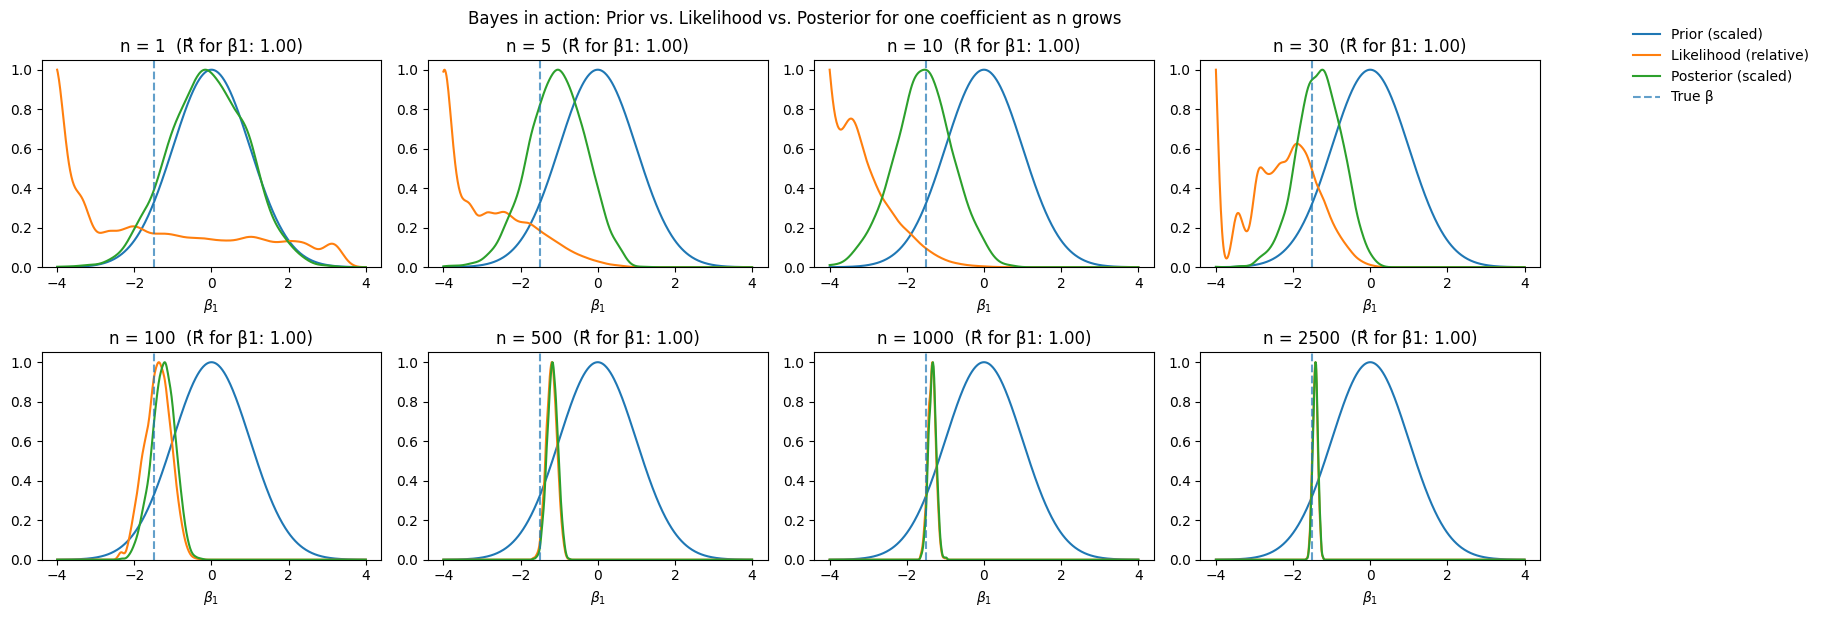

In [28]:
# pip install pymc arviz numpy scipy scikit-learn matplotlib
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import norm, gaussian_kde
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

# -----------------------------
# 1) Simulate a dataset once
# -----------------------------
N_FULL, P = 2500, 3
X_full = rng.normal(size=(N_FULL, P))
true_alpha = -0.2
true_beta  = np.array([1.0, -1.5, 0.7])
logit_p = true_alpha + X_full @ true_beta
p_vec = 1 / (1 + np.exp(-logit_p))
y_full = rng.binomial(1, p_vec)

# Use a single scaler so features are on the same scale across all n
scaler = StandardScaler().fit(X_full)
X_full_s = scaler.transform(X_full)

# -----------------------------
# 2) Helper: fit BLR and return posterior draws for beta_k
# -----------------------------
def fit_blr_get_beta_k_draws(X, y, k, sigma_beta=1.0, sigma_alpha=2.0, seed=0):
    with pm.Model() as m:
        Xd = pm.Data("X", X)
        yd = pm.Data("y", y)

        alpha = pm.Normal("alpha", mu=0.0, sigma=sigma_alpha)
        beta  = pm.Normal("beta",  mu=0.0, sigma=sigma_beta, shape=X.shape[1])

        eta = alpha + pm.math.dot(Xd, beta)
        p   = pm.Deterministic("p", pm.math.sigmoid(eta))
        y_obs = pm.Bernoulli("y_obs", p=p, observed=yd)

        idata_synth = pm.sample(
            draws=800, tune=800, chains=3,
            target_accept=0.95, random_seed=seed, progressbar=False
        )

    beta_draws = idata_synth.posterior["beta"].values  # shape: (chains, draws, P)
    beta_draws = beta_draws.reshape(-1, beta_draws.shape[-1])  # (S, P)
    return beta_draws[:, k], idata_synth

# -----------------------------
# 3) Choose coefficient to visualize (k=0 corresponds to true_beta[0]=1.0)
# -----------------------------
k = 1

# Prior for beta_k used in the model
PRIOR_MU, PRIOR_SD = 0.0, 1.0

# Grid for plotting densities
grid = np.linspace(-4, 4, 500)
prior_pdf = norm.pdf(grid, loc=PRIOR_MU, scale=PRIOR_SD)
prior_pdf = np.maximum(prior_pdf, 1e-300)  # avoid divide-by-zero in tails

# -----------------------------
# 4) Fit for multiple n and compute curves
# -----------------------------
Ns = [1, 5, 10, 30, 100, 500, 1000, 2500]
results = []

for i, n in enumerate(Ns):
    idx = rng.choice(N_FULL, size=n, replace=False)
    X_n = X_full_s[idx]
    y_n = y_full[idx]

    beta_k_draws, idata_synth = fit_blr_get_beta_k_draws(X_n, y_n, k, seed=100 + i)

    # Posterior KDE on the grid
    kde = gaussian_kde(beta_k_draws)
    post_pdf = kde(grid)
    post_pdf = np.maximum(post_pdf, 1e-300)

    # Relative likelihood shape: posterior / prior (scale-free)
    like_rel = post_pdf / prior_pdf
    like_rel /= like_rel.max()  # normalize to 1 for plotting
    post_scaled = post_pdf / post_pdf.max()
    prior_scaled = prior_pdf / prior_pdf.max()

    # Optionally check convergence (prints once per n)
    summ = az.summary(idata_synth, var_names=["beta"])  # contains r_hat
    rhat_k = float(summ.loc[f"beta[{k}]", "r_hat"])

    results.append({
        "n": n,
        "post_scaled": post_scaled,
        "like_rel": like_rel,
        "prior_scaled": prior_scaled,
        "rhat_k": rhat_k
    })

# -----------------------------
# 5) Plot small multiples
# -----------------------------
cols = 4
rows = int(np.ceil(len(Ns) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 6))
axes = axes.ravel()

for ax, res in zip(axes, results):
    ax.plot(grid, res["prior_scaled"], label="Prior (scaled)")
    ax.plot(grid, res["like_rel"],     label="Likelihood (relative)")
    ax.plot(grid, res["post_scaled"],  label="Posterior (scaled)")
    ax.axvline(true_beta[k], linestyle="--", alpha=0.7, label="True β" if res["n"]==Ns[0] else None)
    ax.set_title(f"n = {res['n']}  (R̂ for β{k}: {res['rhat_k']:.02f})")
    ax.set_xlabel(fr"$\beta_{k}$")
    ax.set_ylim(0, 1.05)

# Hide any unused subplots
for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()

# Put the legend just outside the top-right of the figure
fig.legend(
    handles, labels,
    loc="upper left",            # corner of the legend that will be placed at...
    bbox_to_anchor=(1.02, 1.0),  # ...this figure-relative point (just right of 1.0)
    borderaxespad=0.0,
    frameon=False
)

# Leave room on the right for the legend
fig.tight_layout(rect=[0, 0, 0.975, 1])
fig.suptitle("Bayes in action: Prior vs. Likelihood vs. Posterior for one coefficient as n grows", y=1.02)
plt.show()

## 4. Uncertainty quantification

The great advantage of Bayesian ML is that the uncertainty w.r.t. the parameter estimates are taken into account when making predictions. The predictive distribution for new data point $(x^*, y^*)$ is given by the weighted sum over the posterior distribution of the model parameters and thereby contains the uncertainty w.r.t. model parameters

$$
\begin{align}
p(y^*=1 \mid \ y, x^*) &= \int p(y^*=1 \mid \ x^*) p(\beta \mid y) d \beta,
\end{align}
$$

where
$$
\begin{align}
p(\beta \mid \ y, X_{train}) &= \frac{p(y \mid \beta, X_{train}) p(\beta)}{{p(y)}}.
\end{align}
$$

The bayesian predictive distribution is also reffered to as the bayesian model average, as the prediction is weighted by the probability of all model parameters consistent with the data.

By samping the posterior predictive distribution we can get the predictions for the first 5 data point of our test set incl. the 90% intervals. We use the mean og the predictive distribution as our prediction and also easily get the 90% intervals from the distribution.

In [29]:
with blr:
    pm.set_data({"X": X_test})
    p_pred = pm.sample_posterior_predictive(idata, var_names=["p"])

# Point predictions (posterior mean prob) and 90% intervals
p_draws = p_pred.posterior_predictive["p"].stack(sample=("chain","draw")).values  # shape: (n_test, n_draws)
p_mean  = p_draws.mean(axis=1)

lower   = np.quantile(p_draws, 0.05, axis=1)
upper   = np.quantile(p_draws, 0.95, axis=1)

print("First 5 predicted probs (mean) with 90% intervals:")
for i in range(5):
    print(f"{p_mean[i]:.3f}  [{lower[i]:.3f}, {upper[i]:.3f}]")


Sampling: []


First 5 predicted probs (mean) with 90% intervals:
0.124  [0.054, 0.224]
0.071  [0.038, 0.115]
0.134  [0.089, 0.188]
0.076  [0.030, 0.146]
0.703  [0.572, 0.817]
